# Markov Chain Monte Carlo Simulations

In [1]:
using Distributions: pdf, rand, Uniform, Normal, Cauchy
using StatsBase: autocor
using DataFrames: DataFrame
using Gadfly

Gadfly.push_theme(:dark)

### Monte Carlo Simulation

In [2]:
draws = collect(1:1:5000);
area = Array{Float64, 1}();

for i in 1:(draws |> size)[1]
  samples = rand(Normal(0, 1), draws[i])
  push!(area, sum(((samples .> -1.96) & (samples .< 1.96)) ./ (samples |> size)[1]))
end

area_df = DataFrame(x = draws, y = area);

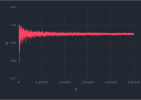

In [3]:
plot(area_df, x = :x, y = :y, Geom.line)

### Metropolis-Hasting

In [4]:
r = 10000;
burnIn = 500;
mu = [10; -10];
sigma = [[1.5^2  1.5*1.35*.5];
         [1.5*1.35*.5 1.35^2]];
x = Array{Float64, 1}(); push!(x, 30);

for i in 1:(r - 1)
  proposal = x[i] + rand(Uniform(-1, 1))
  accept = rand(Uniform()) < (pdf(Cauchy(), proposal) / pdf(Cauchy(), x[i]))

  if accept == true
    push!(x, proposal)
  else
    push!(x, x[i])
  end
end

In [5]:
x_df = DataFrame(x = collect(1:r), y = x);

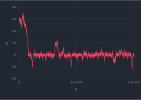

In [6]:
plot(x_df, x = :x, y = :y, Geom.line)

### Gibbs Sampling

In [7]:
function cond_normal(x::Float64; μ1::Float64 = 10., μ2::Float64 = -10., σ1::Float64 = 1.5, σ2::Float64 = 1.35, ρ::Float64 = .5)
  rand(Normal(μ1 + (σ1/σ2) * ρ * (x - μ2), sqrt((1 - ρ^2) * σ1^2)))
end

cond_normal (generic function with 1 method)

In [8]:
x1 = Array{Float64, 1}(); push!(x1, 0.);
x2 = Array{Float64, 1}(); push!(x2, 0.);
for i in 1:r
  push!(x1, cond_normal(x2[i]))
  push!(x2, cond_normal(x1[i + 1], μ1 = -10., μ2 = 10., σ1 = 1.35, σ2 = 1.5))
end
xs_df = DataFrame(x = x1, y = x2);

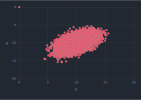

In [9]:
plot(xs_df, x = :x, y = :y, Geom.point)

In [10]:
acf_df = DataFrame(x = collect(0:(length(autocor(x1[(burnIn + 1):r])) - 1)), 
                   acf1 = autocor(x1[(burnIn + 1):r]), 
                   acf2 = autocor(x2[(burnIn + 1):r]));

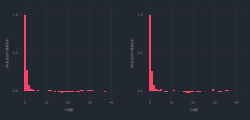

In [11]:
p1 = plot(acf_df, x = :x, y = :acf1, Geom.bar, Guide.xlabel("Lags"), Guide.ylabel("Autocorrelation"), Coord.cartesian(xmin = -2, xmax = 43, ymin = -.1, ymax = 1.1))
p2 = plot(acf_df, x = :x, y = :acf2, Geom.bar, Guide.xlabel("Lags"), Guide.ylabel("Autocorrelation"), Coord.cartesian(xmin = -2, xmax = 43, ymin = -.1, ymax = 1.1))
draw(SVG(25cm, 12cm), hstack(p1, p2))